In [322]:
__author__ = 'Team_4'
__Date__ = 'December 2018'

## Loading Modules

In [323]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from chainer import Chain, Variable, optimizers
import chainer.functions as F
import chainer.links as L
from copy import deepcopy

from gensim.models.keyedvectors import KeyedVectors

import os
__dir__ = os.getcwd()[:-11]

## The LSTM Model

In [324]:
class LSTM(Chain):
    def __init__(self, in_size, hidden_size,out_size):
        super(LSTM, self).__init__(
            h1 = L.NStepLSTM (
                n_layers=1,
                in_size=in_size,
                out_size=hidden_size,
                dropout=0.5),
            hy = L.Linear(hidden_size,out_size))


    def __call__(self,input_data,hx=None):
        if np.any(hx):
            hx = hx.reshape(1,-1,self.h1.out_size)
        input_x = [Variable(x) for x in input_data]
        hx,cx,y = self.h1(hx,None,input_x)
        out = [self.hy(item) for item in y]
        return out

    def predict(self,word,hx=None):
        test_vec = word_to_index(word)
        test_vec = one_hot_encoding(test_vec).astype(np.float32)
        res = self([test_vec],hx)[0]
        return F.softmax(res)

## Functions for arrangement

In [325]:
def padding(sentences):
    max_len = np.max([len(s) for s in sentences])
    paded_vec = []
    for sentence in sentences:
        pad_len = max_len - len(sentence)
        pad_vec = [26] * pad_len
        sentence.extend(pad_vec)
        paded_vec.append(sentence)

    return np.array(paded_vec,dtype=np.int32)

def one_hot_encoding(indices,n_class=27):
    return np.eye(n_class)[indices]

def word_to_index(word,end=True):
    word_index = [ord (char) - 97 for char in word]
    if end:
        word_index.extend([26])
    return word_index

## Preparing the dataset and convert it to vector expression

In [475]:
df = pd.read_csv(__dir__ + 'data/suffled_split_point.csv',index_col=0)
#df = df[np.random.permutation(df.columns.values)]
#df.to_csv(__dir__ + 'suffled_spit_point.csv')

## Sampling the training dataset 

In [487]:
df = df[df.columns[:1500]]
training_data = [word_to_index(x) for x in df.columns]
#reversed_training_data = [x[::-1] for x in training_data]
#training_data.extend(reversed_training_data)

## Data Arrangement

In [486]:
word_vectors = KeyedVectors.load_word2vec_format(__dir__ + 'data/glove.6B.50d.bin')

In [488]:
word_vec = np.array([word_vectors.get_vector(word) for word in df.columns], dtype=np.float32)
#word_vec = np.tile(word_vec,(2,1))

In [489]:
original_data = [word_to_index(x) for x in df.columns]
original_data = [one_hot_encoding(x).astype(np.float32) for x in original_data]

trainX = [data[:-1] for data in original_data]
trainY = [F.argmax(data[1:],axis=1) for data in original_data]

## Defining the LSTM model and setting the optimizer

In [490]:
model = LSTM(27, 50, 27)
optimizer = optimizers.Adam()
optimizer.setup(model)

## Training

In [491]:
model.train = True
loss_record = []
for i in range(2000):
    model.cleargrads()
    pred = model(trainX,word_vec)
    loss = 0
    for X,Y in zip(pred,trainY):
        loss += F.softmax_cross_entropy(X,Y)

    loss_record.append(float(loss.data))
    loss.backward()
    optimizer.update()

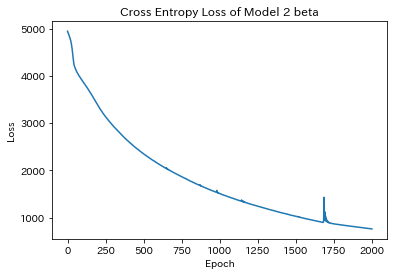

In [494]:
plt.plot(loss_record)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Cross Entropy Loss of Model 2 beta')
plt.show()

In [520]:
model.train = False

#df = pd.read_csv(__dir__ + 'data/suffled_spit_point.csv',index_col=0)
target = df.columns[0]
hidden = word_vectors.get_vector(target)
res = model.predict(target,hidden).data[:-1]
res = model.predict(target).data[:-1]

pre_state = 0
for i,proba in enumerate(res):
    proba = np.array([proba])
    pred = np.apply_along_axis(chr,0, np.argsort(proba) + 97)[::-1]
    proba = np.sort(proba)[0][::-1]
    pred = np.where(pred=='{','end',pred)
    prob = np.round(proba,5)
    cadidate = {char:p for char,p in zip(pred,prob)}
    top_cadidate = {char:p for char,p in zip(pred[:3],prob[:3])}
    confidence =  np.var(prob[:2])
    try:
        occurrence_prob = cadidate[target[i+1]]
    except:
        occurrence_prob = cadidate['end']
    conf = np.sum(prob > 0.3)
    
    confidence_diff = np.round(1000*(confidence-pre_state),2)
    print('input {} :'.format(target[i]),top_cadidate,'confidence Flu.:',confidence_diff)
    pre_state = confidence

input t : {'o': 0.33372, 'e': 0.27056, 'h': 0.16133} confidence Flu.: 1.0
input e : {'r': 0.79984, 'd': 0.04072, 'l': 0.04067} confidence Flu.: 143.07
input s : {'t': 0.58885, 'h': 0.20045, 'c': 0.11182} confidence Flu.: -106.35
input t : {'u': 0.8186, 'r': 0.07511, 'i': 0.04182} confidence Flu.: 100.48
input s : {'end': 0.5965, 'u': 0.28697, 'y': 0.05886} confidence Flu.: -114.24


## Saving the model

In [510]:
from chainer import serializers
serializers.save_npz(__dir__ + 'data/model_2_beta',model)

In [517]:
target

'declines'